In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import gc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from sklearn.ensemble import RandomForestClassifier
from rdkit import DataStructs

In [ ]:
seed = 42

In [ ]:
def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
train = pd.read_csv('train_data.txt', sep='\t')
train = train.rename(columns={'Smiles String': 'Smiles', 'agg' : 'label'})

test_agg = pd.read_csv('agg_data_test.txt', sep='\t')
test_agg['label']='AGG'
test_agg.drop('ID', axis=1, inplace = True)

test_non_agg= pd.read_csv('nonagg_data_test.txt', sep='\t')
test_non_agg['label']='NONAGG'
test_non_agg.drop('ID', axis=1, inplace = True)

data = pd.concat([test_agg, test_non_agg, train], ignore_index=True)

data = data.rename(columns={'label': 'labels','Smiles' : 'smiles' })

label_map = {
    'AGG': 1,
    'NONAGG': 0,
}

data = data.drop('Unnamed: 0', axis=1 )
data['labels'] = data['labels'].map(label_map)
data.dropna(inplace=True)

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

In [ ]:
majority_class = train_df1[train_df1['labels'] == 0]
minority_class = train_df1[train_df1['labels'] == 1]

majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)

train_df1 = pd.concat([minority_class, majority_undersampled])

In [ ]:
# Add Mol column
PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
moldf = train_df1[pd.notnull(train_df1['Mol'])]

In [ ]:
moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
y = moldf['labels'].to_numpy()
X.shape

(372, 2048)

In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [None, 5, 10, 20],
    'min_impurity_decrease': [0.0, 0.3]
}

rf = RandomForestClassifier(bootstrap=True, class_weight=None,
                            min_weight_fraction_leaf=0.0,
                            n_jobs=-1, oob_score=False, random_state=seed)

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the data
grid_search.fit(X, y)

In [ ]:
# Print the best parameters and corresponding accuracy score
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
# Optionally, you can evaluate the best model on the test set
best_model = grid_search.best_estimator_

## Test evaluation

In [ ]:
PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
test = test_df1[pd.notnull(test_df1['Mol'])]

In [ ]:
test['Descriptors'] = test.Mol.apply(calcfp)
X = np.array(list(test['Descriptors'])).astype(int)
y = test['labels'].to_numpy()

In [ ]:
preds = best_model.predict(X)
probs = best_model.predict_proba(X)[:, 1]

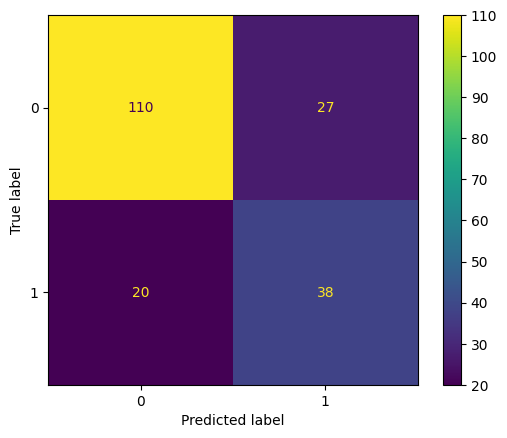

In [ ]:
cm = confusion_matrix(y, preds)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.6551724137931034
spe:0.8029197080291971
CCR:0.7290460609111502
ppv:0.5846153846153846
nen:0.8461538461538461


In [ ]:
# Calculate the AUC score
auc_score = roc_auc_score(y, probs)

print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.8318650893531335


## Ten runs:

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        #balance the traininng data
        majority_class = train_df1[train_df1['labels'] == 0]
        minority_class = train_df1[train_df1['labels'] == 1]
        majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)
        train_df1 = pd.concat([minority_class, majority_undersampled])

        # preparing data for training
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        moldf = train_df1[pd.notnull(train_df1['Mol'])]

        moldf['Descriptors'] = moldf.Mol.apply(calcfp)
        X = np.array(list(moldf['Descriptors'])).astype(int)
        y = moldf['labels'].to_numpy()

        # fit the model
        best_model.random_state=seed
        best_model.fit(X,y)

        # prepare evaluation dataevaluation
        PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        test = test_df1[pd.notnull(test_df1['Mol'])]

        test['Descriptors'] = test.Mol.apply(calcfp)
        X = np.array(list(test['Descriptors'])).astype(int)
        y = test['labels'].to_numpy()

        #predict and evaluate
        preds = best_model.predict(X)
        probs = best_model.predict_proba(X)[:, 1]

        cm = confusion_matrix(y, preds)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))

        auc_score = roc_auc_score(y, probs)

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(auc_score)

        print('finished run:', len(ccr_list))

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

finished run: 1
finished run: 2
finished run: 3
finished run: 4
finished run: 5
finished run: 6
finished run: 7
finished run: 8
finished run: 9
finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.71 ± 0.03
Mean and Standard Deviation of Sensitivity: 0.65 ± 0.05
Mean and Standard Deviation of Specificity: 0.76 ± 0.05
Mean and Standard Deviation of PPV: 0.54 ± 0.05
Mean and Standard Deviation of NPV: 0.84 ± 0.02
Mean and Standard Deviation of AUC: 0.79 ± 0.02
